<a href="https://colab.research.google.com/github/rtldr/DeepDecompiler/blob/master/DeepDecompiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip3 install pyelftools

     |████████████████████████████████| 153kB 12.4MB/s 


In [4]:
# DATA_FOLDER_PATH = 'drive/MyDrive/data'
# Upload the tar.gz data files to the VM and tar -xzvf them
DATA_V2_FOLDER_PATH = 'data_v2'
DATA_V3_FOLDER_PATH = 'data_v3'


In [6]:
# Simple asm tokenizer - TODO maybe look into better ways of doing this
from elftools.elf.elffile import ELFFile

NUM_TOKENS = 2**8 + 2
EOF = 256
PAD = 257

def tokenize_asm_file(filename):
    with open(filename, "rb") as f:
        elf_file = ELFFile(f)
        for section in elf_file.iter_sections():
            if section.name == '.text':
                bytes_list = list(section.data())
    # Add EOF
    bytes_list.append(EOF)
    return bytes_list
    
if __name__ == "__main__":
    m = 0
    count = 0
    for i in range (1024):
        tokenized = tokenize_asm_file(DATA_V2_FOLDER_PATH + "/asm/" + str(i))
        if len(tokenized) < 100:
            count += 1
            m = max(m, len(tokenized))
    print(m)
    print(count)


99
756


In [8]:
# C Tokenizer

from pycparser.c_lexer import CLexer

# C token space
# 0 - 99 tokens generated by CLexer
# 100 - 227 printable ASCII characters (100 -> Ascii 32) TODO - switch to byte pair encodings
# 228 - END_ID_CONST
# 229 - END_LITERAL
# 230 - EOF
# 231 - SOS 
EOF = 100
SOS = 101
PAD = 102
NUM_TOKENS = 103
# EOF = 230
# SOS = 231
# NUM_TOKENS = 232

class CTokenizer():
    def __init__(self):
        self.lexer = CLexer(self._on_error, self._on_left_brace, self._on_left_brace, self._type_lookup_func)
        self.lexer.build(optimize=True, lextab='pycparser.lextab', outputdir='')
        self.semicolon_token = self.lexer.tokens.index('SEMI')

    # Lexer Functions
    def _on_error(self, msg, line, column):
        print("Error tokenizing:", msg)

    def _on_left_brace(self):
        pass

    def _on_right_brace(self):
        pass

    def _type_lookup_func(self, name):
        return False

    def tokenize_file(self, filename, include_SOS=False):
        with open(filename) as f:
            # Skip first line of file
            f.readline()
            text = f.read()
        tokens = []
        self.lexer.input(text)
        t = self.lexer.token()
        while t is not None:
            tokens += self._process_lexer_token(t)
            t = self.lexer.token()
        tokens.append(EOF)

        # Strip header info by removing everything before first two semicolons
        tokens = tokens[tokens.index(self.semicolon_token) + 1:]
        tokens = tokens[tokens.index(self.semicolon_token) + 1:]

        return [SOS] + tokens if include_SOS else tokens 
    
    # Required because of BaseTokenizer
    def tokenizer(text):
      # Assume text is the actual C code
      tokens = []
      self.lexer.input(text)
      t = self.lexer.token()
      while t is not None:
          tokens += self._process_lexer_token(t)
          t = self.lexer.token()
      tokens.append(EOF)

      # Strip header info by removing everything before first two semicolons
      tokens = tokens[tokens.index(self.semicolon_token) + 1:]
      tokens = tokens[tokens.index(self.semicolon_token) + 1:]
      output = [SOS] + tokens if include_SOS else tokens
      return tokens_to_string(output).split()

    def add_special_cases(toks):
      pass

    def _process_lexer_token(self, ltoken):
        ltype = ltoken.type
        token = [self.lexer.tokens.index(ltype)]

        # if "LITERAL" in ltype:
        #     value = ltoken.value[1:-1]
        #     for char in value:
        #         token.append(ord(char) + 100 - 32)
        #     token.append(229)
        # elif ("CONST" in ltype and ltype != "CONST") or ltype == "ID":
        #     value = ltoken.value
        #     for char in value:
        #         token.append(ord(char) + 100 - 32)
        #     token.append(228)

        return token

    def tokens_to_string(self, tokens):
        result = ""
        for token in tokens:
            if 0 <= token < 100:
                result += " " + self.lexer.tokens[token]
            elif 100 <= token < 228:
                result += chr(token - 100 + 32)
            elif token == 228:
                result += "END_ID_CONST"
            elif token == 229:
                result += "END_STR_LITERAL"
            elif token == EOF:
                result += " EOF"
            else:
                result += " UNKNOWN_TOKEN"

        return result[1:]
        
    def tokens_to_C_string(self, tokens):
        C_dict = {
            "LPAREN" : '(',
            "RPAREN" : ')',
            # Operators
            "PLUS" : '+',
            "MINUS" : '-',
            "TIMES" : '*',
            "DIVIDE" : '/',
            "MODULO" : '%',
            "OR" : '|',
            "AND" : '&',
            "NOT" : '~',
            "XOR" : '^',
            "LSHIFT" : '<<',
            "RSHIFT" : '>>',
            "LOR" : '||',
            "LAND" : '&&',
            "LNOT" : '!',
            "LT" : '<',
            "GT" : '>',
            "LE" : '<=',
            "GE" : '>=',
            "EQ" : '==',
            "NE" : '!=', 
            # Assignment Operators
            "EQUALS" : '=',
            "TIMESEQUAL" : '*=',
            "DIVEQUAL" : '=',
            "MODEQUAL" : '=',
            "PLUSEQUAL" : '+=',
            "MINUSEQUAL" : '-=',
            "LSHIFTEQUAL" : '<<=',
            "RSHIFTEQUAL" : '>>=',
            "ANDEQUAL" : '&=',
            "OREQUAL" : '|=',
            "XOREQUAL" : '^=',
            # Increment/decrement
            "PLUSPLUS" : '++',
            "MINUSMINUS" : '--',
            # ->
            "ARROW" : '->',
            # ?
            "TERNARY" : '?',
            # Delimeters
            "LPAREN" : '(',
            "RPAREN" : ')',
            "LBRACKET" : '[',
            "RBRACKET" : ']',
            "BRACE" : '{',
            "RBRACE" : '}',
            "COMMA" : ',',
            "PERIOD" : '.',
            "SEMI" : ';',
            "COLON" : ':',
            "ELLIPSIS" : '...',
            
        }
        result = ""
        for_semi = 0
        indent = 0; 
        tab = "    "
        for token in tokens:
            if 0 <= token < 100:
                token_str = self.lexer.tokens[token]
                if token_str == "LBRACE":
                    result += "\n" + indent*tab
                    indent += 1
                    result += "{\n" + indent*tab
                elif token_str == "RBRACE":
                    indent -= 1
                    result += "\n" + indent*tab
                    result += "}\n" + indent*tab
                elif token_str == "FOR":
                    result += "for"
                    for_semi = 2
                elif token_str == "SEMI":
                    result += ";"
                    if for_semi > 0:
                        for_semi -= 1
                    else: 
                        result += "\n" + indent*tab
                elif token_str in C_dict: 
                    result += C_dict[token_str]
                else: 
                    result += " " + self.lexer.tokens[token].lower()
            elif 100 <= token < 228:
                 result += chr(token - 100 + 32)
            elif token == 228:
                result += "end_id_const"
            elif token == 229:
                result += "end_str_literal"
            elif token == EOF:
                result += " eof"
            else:
                result += " unknown_token"

        return result[1:]


if __name__ == "__main__":
    tkn = CTokenizer()
    tokens = tkn.tokenize_file(DATA_V2_FOLDER_PATH + "/c/0.c")
    print(tkn.tokens_to_string(tokens))
    print(tkn.tokens_to_C_string(tokens))


STATIC ID ID LPAREN VOID RPAREN LBRACE ID ID EQUALS INT_CONST_HEX SEMI RETURN ID SEMI RBRACE 
static id id( void)
{
     id id= int_const_hex;
     return id;
    
}
 


In [10]:
f = open('train_c_30000.csv', 'a')
for i in range (30000):
  tkn = CTokenizer()
  tokens = tkn.tokenize_file(DATA_V2_FOLDER_PATH + "/c/" + str(i) + ".c")
  line = str.lower(tkn.tokens_to_string(tokens)) + '\n'
  f.write(line)
f.close()

In [72]:
f = open('train_asm_30000.csv', 'a')
for i in range (30000):
  tokens = tokenize_asm_file(DATA_V2_FOLDER_PATH + "/asm/" + str(i))
  str_tokens = [str(j) for j in tokens]
  line = ' '
  line = line.join(str_tokens) + '\n'
  f.write(line)
f.close()

In [44]:
! [ -e /content ] && pip install -Uqq fastai
from fastai import *
from fastai.text import *

In [ ]:
# # Create C data loader
# c_tokenizer = CTokenizer()
# train_tokens = []
# train_labels = []
# TRAIN_NUM = 1000
# for i in range(TRAIN_NUM):
#   c_tokens_int = c_tokenizer.tokenize_file(DATA_V2_FOLDER_PATH + '/c/' + str(i) + '.c')
#   c_tokens_str = [str(j) for j in c_tokens_int]
#   train_tokens.append(c_tokens_str)
#   train_labels.append(True)

# VAL_NUM = 300
# val_tokens = []
# val_labels = []
# for i in range(TRAIN_NUM, TRAIN_NUM + VAL_NUM):
#   c_tokens_int = c_tokenizer.tokenize_file(DATA_V2_FOLDER_PATH + '/c/' + str(i) + '.c')
#   c_tokens_str = [str(j) for j in c_tokens_int]
#   val_tokens.append(c_tokens_str)
#   val_labels.append(True)

# tdb = TextDataBunch.from_tokens('./', train_tokens, train_labels, val_tokens, val_labels)

# class CDataset(Dataset):
#   def __init__(self, start_index, stop_index):
#     c_tokenizer = CTokenizer()
#     self.tokens = []
#     vocab_len_upper_bound = 0
#     for i in range(start_index, stop_index):
#       tokens.append(c_tokenizer.tokenize_file(DATA_V2_FOLDER_PATH + '/c/' + str(i) + '.c'))
#       c_tokens_str = [str(j) for j in c_tokens_int]
#       self.tokens.append(c_tokens_str)
#       vocab_len_upper_bound += len(c_tokens_str)
#     self.vocab = Vocab.create(self.tokens, vocab_len_upper_bound, 1)

#   def __getitem__(self, index):
#     return self.tokens[index]

#   def __len__(self):
#     return len(self.tokens)

# train_dataset = CDataset(0, 1000)
# train_loader = LMDataLoader(dataset=train_dataset)
# val_dataset = CDataset(1000, 1500)
# val_loader = LMDataLoader(dataset=val_dataset)

# data_lm = TextLMDataBunch(train_loader, val_loader)


# Use ASM numbers as tokens for the model
# Use C numbers as tokens for the model

# Model thinks str(numbers) are actual words.

# Model trains on C str(numbers), spits out a C str(number). We convert all these str(numbers) to C code 
# strings to see what the model is spitting out


In [73]:
data_lm = TextLMDataBunch.from_csv('.', 'train_asm_30000.csv', text_cols=0)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# def tdb_item_to_C_code(item):
#   int_arr = [int(i) for i in item]
#   return c_tokenizer.tokens_to_C_string(int_arr)

# item_idx = 4
# code = tdb_item_to_C_code(data_lm.train_ds[item_idx])
# print(code)
# data_lm

In [ ]:
data_lm.show_batch()

In [81]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.2, pretrained=False)
learn_lm.predict('equals', n_words=10)

'equals 244 186 254 196 7 30 248 244 85 233'

In [82]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


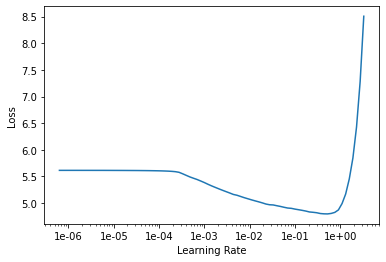

In [83]:
learn_lm.recorder.plot()

In [89]:

lr = 1e-02


In [90]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.291428,4.199733,0.114286,00:36


In [91]:
learn_lm.unfreeze()

In [92]:
learn_lm.fit(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.474190,1.323330,0.657143,00:38
1,2.164698,1.065715,0.671429,00:38
2,2.047236,0.875452,0.771429,00:37
3,2.002676,0.931007,0.714286,00:36
4,1.972137,0.827946,0.757143,00:36
5,1.945591,0.786983,0.814286,00:36
6,2.010497,0.779283,0.814286,00:36
7,2.071677,0.818450,0.757143,00:37
8,1.967330,0.758890,0.771429,00:36
9,1.972574,0.803359,0.771429,00:37


In [93]:
learn_lm.save("ASM_AWD_LSTM_saved_80", return_path=True)

PosixPath('models/ASM_AWD_LSTM_saved_80.pth')